In [13]:
# Install Kaggle API to download the dataset (if not already installed)
!pip install kaggle --quiet

import os
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm


In [ ]:
# run if you are using colab

# Upload your Kaggle API key (JSON file) to access Kaggle datasets
from google.colab import files

# Prompt user to upload kaggle.json file (Get it from your Kaggle account settings)
print("Please upload your kaggle.json file.")
files.upload()

# Set up Kaggle API credentials
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the wildfire dataset from Kaggle
!kaggle datasets download -d abdelghaniaaba/wildfire-prediction-dataset --unzip

# Check dataset directory
!ls

In [ ]:
# run if you're not on colab
!kaggle datasets download -d abdelghaniaaba/wildfire-prediction-dataset --unzip --force

Dataset URL: https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset
License(s): other
100%|█████████████████████████████████████▉| 1.44G/1.45G [00:32<00:00, 50.7MB/s]
100%|██████████████████████████████████████| 1.45G/1.45G [00:32<00:00, 47.4MB/s]


Number of training images: 30250
Number of validation images: 6300
Number of test images: 6300

Training classes: ['nowildfire', 'wildfire']
Validation classes: ['nowildfire', 'wildfire']


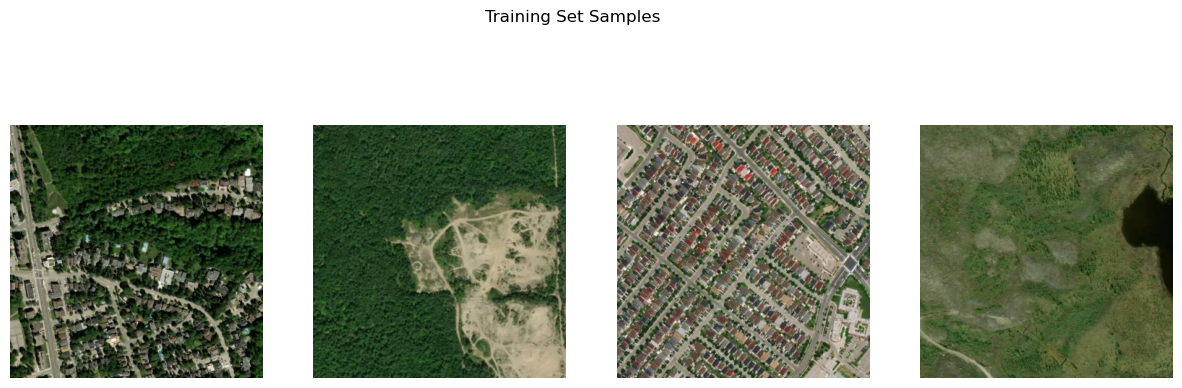

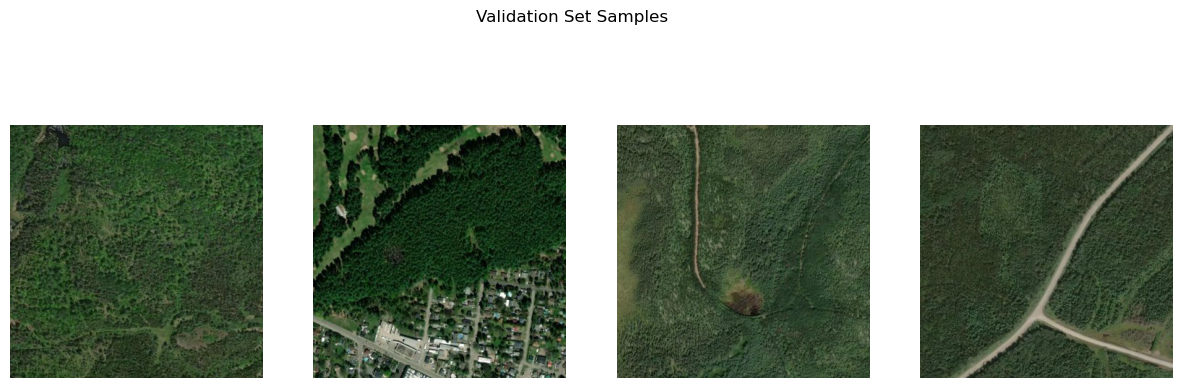

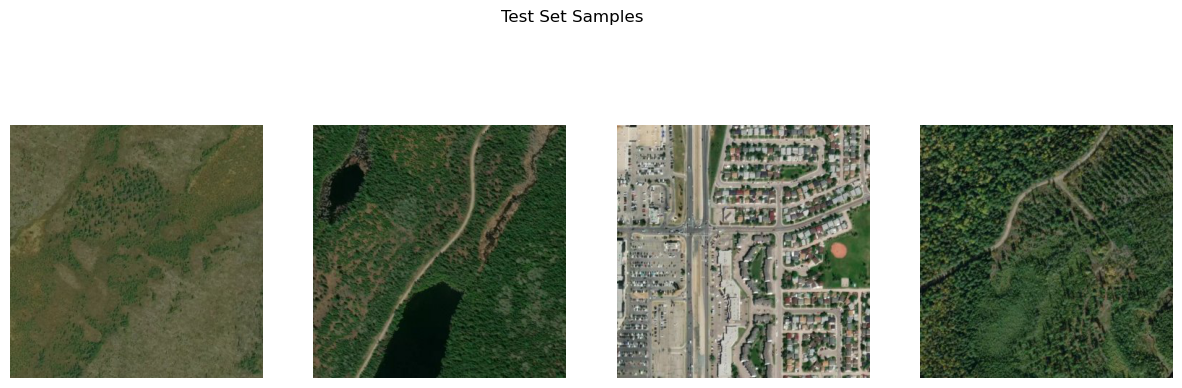

In [15]:
import os
from glob import glob

# Define dataset directories
train_dir = "train"
valid_dir = "valid"
test_dir = "test"

# Check number of images in each directory
num_train = len(glob(os.path.join(train_dir, "**/*.jpg"), recursive=True))
num_valid = len(glob(os.path.join(valid_dir, "**/*.jpg"), recursive=True))
num_test = len(glob(os.path.join(test_dir, "**/*.jpg"), recursive=True))

print(f"Number of training images: {num_train}")
print(f"Number of validation images: {num_valid}")
print(f"Number of test images: {num_test}")

# Check class distribution in training and validation sets
train_classes = os.listdir(train_dir)
valid_classes = os.listdir(valid_dir)

print("\nTraining classes:", train_classes)
print("Validation classes:", valid_classes)

# Display some images from the dataset
import matplotlib.pyplot as plt
import random
from PIL import Image

# Function to show random images
def show_random_images(folder, title, num_images=4):
    images = glob(os.path.join(folder, "**/*.jpg"), recursive=True)
    random_images = random.sample(images, num_images)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, img_path in enumerate(random_images):
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.suptitle(title)
    plt.show()

# Show random images from each dataset
show_random_images(train_dir, "Training Set Samples")
show_random_images(valid_dir, "Validation Set Samples")
show_random_images(test_dir, "Test Set Samples")


In [16]:
import shutil
from sklearn.model_selection import train_test_split

# Define new directories for our split datasets
new_train_dir = "new_train"
new_valid_dir = "new_valid"

# Create directories if they don't exist
os.makedirs(new_train_dir, exist_ok=True)
os.makedirs(new_valid_dir, exist_ok=True)

for class_name in os.listdir(valid_dir):  # Iterate over "wildfire" and "no_wildfire"
    class_path = os.path.join(valid_dir, class_name)
    images = glob(os.path.join(class_path, "*.jpg"))

    # Split images into new training (80%) and new validation (20%) sets
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    # Create class folders in new directories
    os.makedirs(os.path.join(new_train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(new_valid_dir, class_name), exist_ok=True)

    # Move files to new directories
    for img in train_images:
        shutil.move(img, os.path.join(new_train_dir, class_name, os.path.basename(img)))

    for img in val_images:
        shutil.move(img, os.path.join(new_valid_dir, class_name, os.path.basename(img)))

print("✅ Validation dataset split successfully!")
print(f"New Train Set: {len(glob(os.path.join(new_train_dir, '**/*.jpg'), recursive=True))} images")
print(f"New Validation Set: {len(glob(os.path.join(new_valid_dir, '**/*.jpg'), recursive=True))} images")


✅ Validation dataset split successfully!
New Train Set: 5040 images
New Validation Set: 1260 images


In [18]:
from torchvision.datasets import ImageFolder

# Set batch size and number of workers
batch_size = 32
num_workers = os.cpu_count() # set =4 for colab

# Define image transformations for data augmentation and normalization
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),   
    transforms.RandomHorizontalFlip(), # Data augmentation (flips)
    transforms.RandomRotation(10),     # Data augmentation (rotation)
    transforms.ToTensor(),             # Convert image to tensor
])

valid_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Load datasets
train_dataset = ImageFolder(new_train_dir, transform=train_transforms)
valid_dataset = ImageFolder(new_valid_dir, transform=valid_transforms)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Check dataset structure
print(f" New Training Set: {len(train_dataset)} images, {len(train_dataset.classes)} classes")
print(f" New Validation Set: {len(valid_dataset)} images, {len(valid_dataset.classes)} classes")
print("Class Names:", train_dataset.classes)

# Check one batch of images
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")  # Should be (batch_size, 3, 224, 224)
    break


 New Training Set: 5040 images, 2 classes
 New Validation Set: 1260 images, 2 classes
Class Names: ['nowildfire', 'wildfire']
Batch shape: torch.Size([32, 3, 256, 256])


In [19]:
# Custom Dataset to Load Images WITHOUT Labels
class UnlabeledDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        # Collect all image paths in the train directory
        for subdir in os.listdir(root_dir):  # Ignore subfolder names (which are labels)
            full_path = os.path.join(root_dir, subdir)
            if os.path.isdir(full_path):
                self.image_paths += [os.path.join(full_path, f) for f in os.listdir(full_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Load image
        if self.transform:
            image = self.transform(image)
        return image  # No labels returned

# Set batch size and number of workers
batch_size = 32
num_workers = os.cpu_count()

# Define transformations
unsupervised_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Load the training dataset without labels
unlabeled_train_dataset = UnlabeledDataset("train", transform=unsupervised_transforms)
unlabeled_train_loader = DataLoader(unlabeled_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Check one batch of images
for images in unlabeled_train_loader:
    print(f"Unlabeled Batch size: {images.shape}")
    break


Unlabeled Batch size: torch.Size([32, 3, 256, 256])


In [20]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder (Feature Extractor)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
        # Decoder
        self.decoder = nn.Sequential(            
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize Autoencoder Model
autoencoder = Autoencoder().to(device)

# Define Loss and Optimizer
learning_rate = 0.01

criterion = nn.MSELoss()  # Mean Squared Error for image reconstruction
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

# Print Model Summary
print(autoencoder)


Using device: cuda:2
Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=Fa

In [21]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # Fix for truncated image issue

num_epochs = 20
save_best_model = True
best_val_loss = float("inf")

# Training loop for autoencoder
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    # training
    train_epoch_loss = 0
    autoencoder.train()

    for images in tqdm(unlabeled_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)

        optimizer.zero_grad()
        outputs = autoencoder(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.item()

    train_losses.append(train_epoch_loss)
    
    # validation
    valid_epoch_loss = 0
    autoencoder.eval()

    with torch.no_grad():
        for images, _ in valid_loader:
            images = images.to(device)
            outputs = autoencoder(images)
            loss = criterion(outputs, images)
            valid_epoch_loss += loss.item()
        
    valid_losses.append(valid_epoch_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train loss: {train_epoch_loss:.6f}, Val loss : {valid_epoch_loss:.6f}")

    # save the best model
    if save_best_model and valid_epoch_loss < best_val_loss:
        best_val_loss = valid_epoch_loss
        torch.save(autoencoder.encoder.state_dict(), "encoder_weights.pth")
        torch.save(autoencoder.state_dict(), "autoencoder_weights.pth")

# save losses for plotting
np.save("AE_train_losses.npy", np.array(train_losses))
np.save("AE_valid_losses.npy", np.array(valid_losses))


Epoch 1/20: 100%|██████████| 946/946 [00:49<00:00, 19.26it/s]


Epoch [1/20], Train loss: 4.409049, Val loss : 0.084221


Epoch 2/20: 100%|██████████| 946/946 [00:49<00:00, 19.02it/s]


Epoch [2/20], Train loss: 1.993417, Val loss : 0.052645


Epoch 3/20: 100%|██████████| 946/946 [00:49<00:00, 19.07it/s]


Epoch [3/20], Train loss: 1.704142, Val loss : 0.029110


Epoch 4/20: 100%|██████████| 946/946 [00:50<00:00, 18.91it/s]


Epoch [4/20], Train loss: 1.471707, Val loss : 0.020826


Epoch 5/20: 100%|██████████| 946/946 [00:49<00:00, 18.93it/s]


Epoch [5/20], Train loss: 1.338695, Val loss : 0.031196


Epoch 6/20: 100%|██████████| 946/946 [00:50<00:00, 18.89it/s]


Epoch [6/20], Train loss: 1.245865, Val loss : 0.040195


Epoch 7/20: 100%|██████████| 946/946 [00:49<00:00, 19.02it/s]


Epoch [7/20], Train loss: 1.139411, Val loss : 0.021726


Epoch 8/20: 100%|██████████| 946/946 [00:49<00:00, 18.94it/s]


Epoch [8/20], Train loss: 1.091367, Val loss : 0.017093


Epoch 9/20: 100%|██████████| 946/946 [00:50<00:00, 18.92it/s]


Epoch [9/20], Train loss: 1.076826, Val loss : 0.017309


Epoch 10/20: 100%|██████████| 946/946 [00:49<00:00, 19.01it/s]


Epoch [10/20], Train loss: 1.036911, Val loss : 0.014718


Epoch 11/20: 100%|██████████| 946/946 [00:49<00:00, 18.93it/s]


Epoch [11/20], Train loss: 0.999470, Val loss : 0.025365


Epoch 12/20: 100%|██████████| 946/946 [00:50<00:00, 18.83it/s]


Epoch [12/20], Train loss: 0.940266, Val loss : 0.016878


Epoch 13/20: 100%|██████████| 946/946 [00:50<00:00, 18.89it/s]


Epoch [13/20], Train loss: 0.972250, Val loss : 0.011651


Epoch 14/20: 100%|██████████| 946/946 [00:49<00:00, 18.99it/s]


Epoch [14/20], Train loss: 0.913844, Val loss : 0.015327


Epoch 15/20: 100%|██████████| 946/946 [00:49<00:00, 19.00it/s]


Epoch [15/20], Train loss: 0.898156, Val loss : 0.020111


Epoch 16/20: 100%|██████████| 946/946 [00:50<00:00, 18.80it/s]


Epoch [16/20], Train loss: 0.881352, Val loss : 0.015343


Epoch 17/20: 100%|██████████| 946/946 [00:50<00:00, 18.80it/s]


Epoch [17/20], Train loss: 0.884274, Val loss : 0.024070


Epoch 18/20: 100%|██████████| 946/946 [00:50<00:00, 18.86it/s]


Epoch [18/20], Train loss: 0.882913, Val loss : 0.018898


Epoch 19/20: 100%|██████████| 946/946 [00:49<00:00, 19.07it/s]


Epoch [19/20], Train loss: 0.837733, Val loss : 0.018985


Epoch 20/20: 100%|██████████| 946/946 [00:50<00:00, 18.87it/s]


Epoch [20/20], Train loss: 0.858501, Val loss : 0.010505


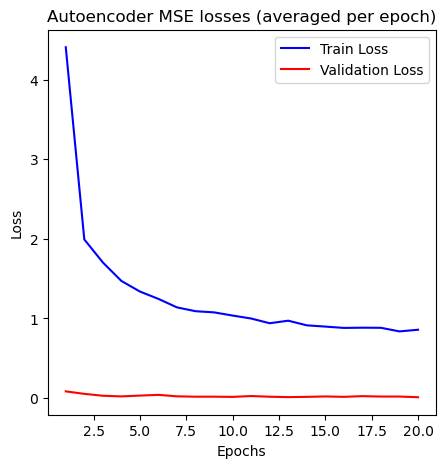

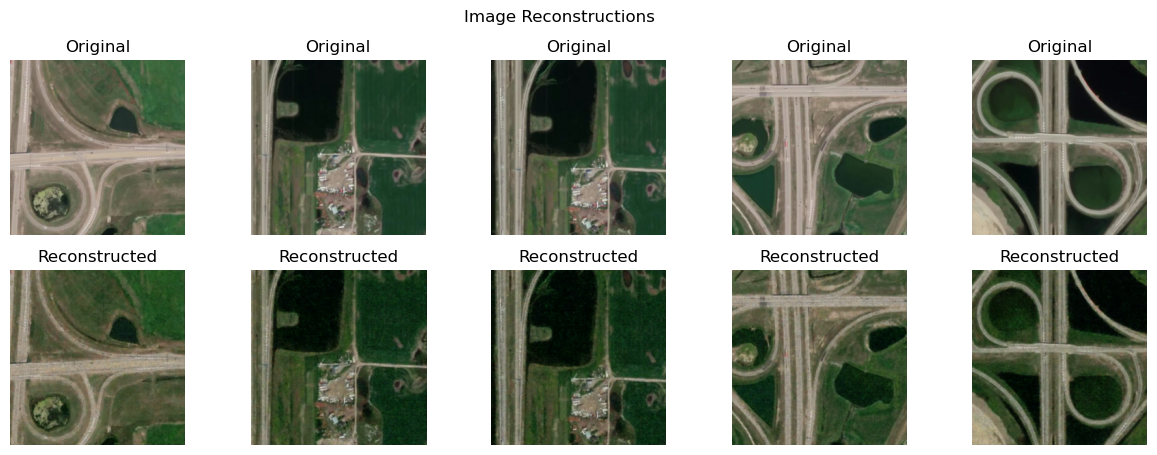

In [22]:
# plot training vs validation loss
ae_train_losses = np.load("AE_train_losses.npy")
ae_valid_losses = np.load("AE_valid_losses.npy")
epochs_len = np.arange(1, len(ae_train_losses) + 1)

plt.figure(figsize=(5, 5))
plt.plot(epochs_len, ae_train_losses,label="Train Loss", color="blue")
plt.plot(epochs_len, ae_valid_losses, label="Validation Loss", color="red")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Autoencoder MSE losses (averaged per epoch)")
plt.show()

# visualize some image reconstructions
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load("autoencoder_weights.pth"))
autoencoder.to(device)

images, _ = next(iter(valid_loader))
images = images.to(device)

with torch.no_grad():
    outputs = autoencoder(images)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 5))
    for i in range(5):
        axes[0, i].imshow(images[i].permute(1, 2, 0).cpu())
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")
        
        axes[1, i].imshow(outputs[i].permute(1, 2, 0).cpu())
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis("off")
    plt.suptitle("Image Reconstructions")
    plt.show()


In [23]:
# Load the pre-trained encoder from the autoencoder
encoder = Autoencoder().encoder  # Extract only the encoder part
encoder.load_state_dict(torch.load("encoder_weights.pth"))
encoder.to(device)

# Define Fire Detection Model with Global Average Pooling
class FireDetectionModel(nn.Module):
    def __init__(self, encoder):
        super(FireDetectionModel, self).__init__()
        self.encoder = encoder  # Pre-trained encoder
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1)) # Reduce dimensions
        self.fc = nn.Linear(256, 1) # classifier layer, input size has to match encoder output size

    def forward(self, x):
        features = self.encoder(x)  # Extract features
        features = self.global_avg_pool(features)  # Apply Global Average Pooling
        features = features.view(features.size(0), -1)  # Flatten
        out = self.fc(features)
        return out

# Initialize Model with Fixed Input Size
model = FireDetectionModel(encoder).to(device)

# Define Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Train only classifier layer

# Print Model Summary
print(model)
print(" Model updated ")


FireDetectionModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
  )
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
 Model updated 


In [24]:
# Training loop parameters
num_epochs = 20
save_best_model = True
best_valid_loss = float("inf")

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    # Training loop
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        
        # apply sigmoid and threshold at 0.5
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100 * correct_train / total_train
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()
    total_valid_loss = 0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)
            
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_valid_loss += loss.item()
            
            # apply sigmoid and threshold at 0.5
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            correct_valid += (preds == labels).sum().item()
            total_valid += labels.size(0)
            
    valid_accuracy = 100 * correct_valid / total_valid
    avg_valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% - Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%")

    # Save the best model
    if save_best_model and avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        torch.save(model.state_dict(), "fire_detection_model.pth")

# Save losses for plotting
np.save("FD_train_losses.npy", np.array(train_losses))
np.save("FD_valid_losses.npy", np.array(valid_losses))

Epoch 1/20: 100%|██████████| 158/158 [00:09<00:00, 16.46it/s]


Epoch [1/20] - Train Loss: 0.3023, Train Acc: 89.72% - Valid Loss: 0.2149, Valid Acc: 91.83%


Epoch 2/20: 100%|██████████| 158/158 [00:09<00:00, 15.81it/s]


Epoch [2/20] - Train Loss: 0.2038, Train Acc: 92.14% - Valid Loss: 0.1912, Valid Acc: 92.14%


Epoch 3/20: 100%|██████████| 158/158 [00:09<00:00, 15.84it/s]


Epoch [3/20] - Train Loss: 0.1783, Train Acc: 93.06% - Valid Loss: 0.1771, Valid Acc: 92.78%


Epoch 4/20: 100%|██████████| 158/158 [00:10<00:00, 15.24it/s]


Epoch [4/20] - Train Loss: 0.1670, Train Acc: 93.75% - Valid Loss: 0.1545, Valid Acc: 93.73%


Epoch 5/20: 100%|██████████| 158/158 [00:09<00:00, 16.29it/s]


Epoch [5/20] - Train Loss: 0.1491, Train Acc: 94.29% - Valid Loss: 0.1507, Valid Acc: 94.60%


Epoch 6/20: 100%|██████████| 158/158 [00:09<00:00, 15.83it/s]


Epoch [6/20] - Train Loss: 0.1447, Train Acc: 94.66% - Valid Loss: 0.1410, Valid Acc: 94.60%


Epoch 7/20: 100%|██████████| 158/158 [00:09<00:00, 16.01it/s]


Epoch [7/20] - Train Loss: 0.1377, Train Acc: 94.82% - Valid Loss: 0.1378, Valid Acc: 94.68%


Epoch 8/20: 100%|██████████| 158/158 [00:09<00:00, 15.98it/s]


Epoch [8/20] - Train Loss: 0.1335, Train Acc: 95.04% - Valid Loss: 0.1369, Valid Acc: 95.08%


Epoch 9/20: 100%|██████████| 158/158 [00:09<00:00, 15.87it/s]


Epoch [9/20] - Train Loss: 0.1319, Train Acc: 95.26% - Valid Loss: 0.1460, Valid Acc: 95.24%


Epoch 10/20: 100%|██████████| 158/158 [00:10<00:00, 15.71it/s]


Epoch [10/20] - Train Loss: 0.1267, Train Acc: 95.24% - Valid Loss: 0.1340, Valid Acc: 95.32%


Epoch 11/20: 100%|██████████| 158/158 [00:10<00:00, 15.48it/s]


Epoch [11/20] - Train Loss: 0.1177, Train Acc: 96.01% - Valid Loss: 0.1356, Valid Acc: 95.63%


Epoch 12/20: 100%|██████████| 158/158 [00:09<00:00, 15.83it/s]


Epoch [12/20] - Train Loss: 0.1195, Train Acc: 95.56% - Valid Loss: 0.1571, Valid Acc: 95.24%


Epoch 13/20: 100%|██████████| 158/158 [00:09<00:00, 15.99it/s]


Epoch [13/20] - Train Loss: 0.1149, Train Acc: 95.91% - Valid Loss: 0.1476, Valid Acc: 94.92%


Epoch 14/20: 100%|██████████| 158/158 [00:09<00:00, 15.84it/s]


Epoch [14/20] - Train Loss: 0.1127, Train Acc: 96.09% - Valid Loss: 0.1374, Valid Acc: 95.63%


Epoch 15/20: 100%|██████████| 158/158 [00:09<00:00, 16.16it/s]


Epoch [15/20] - Train Loss: 0.1148, Train Acc: 95.79% - Valid Loss: 0.1325, Valid Acc: 95.79%


Epoch 16/20: 100%|██████████| 158/158 [00:09<00:00, 16.20it/s]


Epoch [16/20] - Train Loss: 0.1125, Train Acc: 96.05% - Valid Loss: 0.1450, Valid Acc: 95.24%


Epoch 17/20: 100%|██████████| 158/158 [00:09<00:00, 16.60it/s]


Epoch [17/20] - Train Loss: 0.1073, Train Acc: 96.07% - Valid Loss: 0.1351, Valid Acc: 95.95%


Epoch 18/20: 100%|██████████| 158/158 [00:10<00:00, 14.88it/s]


Epoch [18/20] - Train Loss: 0.1097, Train Acc: 96.03% - Valid Loss: 0.1382, Valid Acc: 95.56%


Epoch 19/20: 100%|██████████| 158/158 [00:09<00:00, 15.87it/s]


Epoch [19/20] - Train Loss: 0.1042, Train Acc: 96.05% - Valid Loss: 0.1343, Valid Acc: 95.63%


Epoch 20/20: 100%|██████████| 158/158 [00:10<00:00, 15.71it/s]


Epoch [20/20] - Train Loss: 0.1062, Train Acc: 96.27% - Valid Loss: 0.1496, Valid Acc: 95.40%


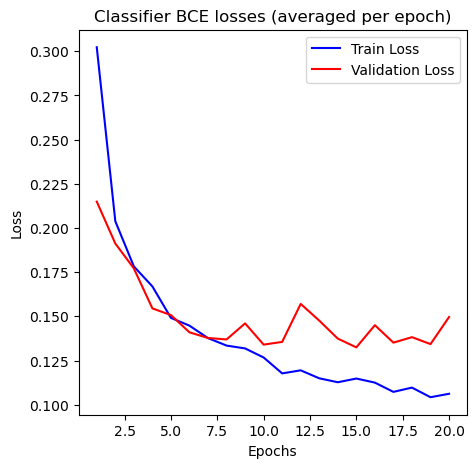

In [25]:
# plot training vs validation loss

fd_train_losses = np.load("FD_train_losses.npy")
fd_valid_losses = np.load("FD_valid_losses.npy")
epochs_len = np.arange(1, len(fd_train_losses) + 1)

plt.figure(figsize=(5, 5))
plt.plot(epochs_len, fd_train_losses,label="Train Loss", color="blue")
plt.plot(epochs_len, fd_valid_losses, label="Validation Loss", color="red")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Classifier BCE losses (averaged per epoch)")
plt.show()

In [26]:
# find best threshold for classification
model.load_state_dict(torch.load("fire_detection_model.pth"))
model.eval()

thresholds = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
best_threshold = 0
best_accuracy = 0

for threshold in thresholds:
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)
            
            outputs = model(images)
            preds = (torch.sigmoid(outputs) >= threshold).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    accuracy = 100 * correct / total
    print(f"Threshold: {threshold}, Accuracy: {accuracy:.2f}%")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold
    
print(f"Best Threshold: {best_threshold}, Best Accuracy on validation set: {best_accuracy:.2f}%")

Threshold: 0.3, Accuracy: 95.00%
Threshold: 0.35, Accuracy: 95.24%
Threshold: 0.4, Accuracy: 95.32%
Threshold: 0.45, Accuracy: 95.56%
Threshold: 0.5, Accuracy: 95.79%
Threshold: 0.55, Accuracy: 95.87%
Threshold: 0.6, Accuracy: 95.71%
Threshold: 0.65, Accuracy: 95.56%
Threshold: 0.7, Accuracy: 95.16%
Best Threshold: 0.55, Best Accuracy on validation set: 95.87%


In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score

# set batch size
batch_size = 32

# Load the test dataset
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

test_dataset = ImageFolder("test", transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the trained model with weights_only=True to fix the warning
model.load_state_dict(torch.load("fire_detection_model.pth", map_location=device, weights_only=True))
model.eval()

# Run inference on the test set
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        preds = (torch.sigmoid(outputs) >= best_threshold).float()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Compute Accuracy
correct_test = sum(p == l for p, l in zip(all_preds, all_labels))
total_test = len(all_labels)
test_accuracy = 100 * correct_test / total_test
print(f"Final Test Accuracy: {test_accuracy[0]:.2f}%")

# Compute additional metrics
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
macro_f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")


Final Test Accuracy: 96.87%
Macro Precision: 0.9680
Macro Recall: 0.9689
Macro F1 Score: 0.9684
